# Myriams Table

In [3]:
from IPython.lib.display import IFrame
IFrame("http://myriamstable.com/", 600, 480)

## Myriams Table has hired you to go through their logs
## Your job is to help them understand these three things

<h3>
    <ol>
        <li>Which resource is the most accessed?</li>
        <li>Who is the most requester?</li>
        <li>If there are 404s occuring, why are they occuring?</li>
    </ol>
</h3>

as a recap, this is how apache log files appear

>201.46.34.200 - - [07/Jul/2015:20:42:30 +0400] "GET /wp-content/themes/MT/images/whbg.png HTTP/1.1" 200 2983 "http://myriamstable.com/" "Mozilla/5.0 (Windows NT 6.1; WOW64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/36.0.1985.143 Safari/537.36"



essentially they follow this format
> url_of_requester (unavailable requester id) (unvailable_remote_ident) (date of access) request protocol code size 

> root_url ua_string
 

In [8]:
URL = 'http://myriamstable.com/logs/access.log'

In [9]:
import re
# the regex for the log
log_re = re.compile(r"(?P<request_ip>\d+\.\d+\.\d+\.\d+)\s(?P<req_id>\S+)\s(?P<remote_id>\S+)\s*\[(?P<date>[^\]]+)\]\s*\"(?P<method>\w+)\s(?P<url>\S+)\s*(?P<protocol>\S+)\"\s*(?P<response>\d{3})\s*(?P<size>\d+)")

sample_log_entry = '201.46.34.200 - - [07/Jul/2015:20:42:30 +0400] "GET /wp-content/themes/MT/images/whbg.png HTTP/1.1" 200 2983 "http://myriamstable.com/" "Mozilla/5.0 (Windows NT 6.1; WOW64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/36.0.1985.143 Safari/537.36"'
# this can be used like so

matches = re.match(log_re, sample_log_entry)

len(matches.groupdict())

9

 data can be arranged in rows with the Spark SQL Row object

```python
row = Row(ip_address = 'ipaddress', date='date', ...)
```

 so the first step is to do some preliminary cleaning: converting date to python datetime obj


In [39]:
import datetime

month_map = {'Jan': 1, 'Feb': 2, 'Mar':3, 'Apr':4, 'May':5, 'Jun':6, 'Jul':7,
    'Aug':8,  'Sep': 9, 'Oct':10, 'Nov': 11, 'Dec': 12}

date_re = re.compile(r'(?P<day>\d{2})/(?P<month>\w{3})/(?P<year>\d{4}):(?P<hour>\d{2}):(?P<minute>\d{2}):(?P<second>\d{2})\s*(?P<tzinfo>\S+)')
date_fmt = "%d/%b/%Y:%H:%M:%S %z"


def stringToDate(apache_date):
    """ Apache date is of the format  07/Jul/2015:20:42:30 +0400
        month must be converted to its numeric value
    """
    match_dict = date_re.match(apache_date).groupdict()
    
    return datetime.datetime(int(match_dict['year']), int(month_map[match_dict['month']]), int(match_dict['day']), 
                             int(match_dict['hour']), int(match_dict['minute']), int(match_dict['second']))
    
stringToDate(matches.groupdict()['date'])

datetime.datetime(2015, 7, 7, 20, 42, 30)

In [11]:
# Row
from pyspark.sql import Row 

def parseLogline(logline):
    """ parses apache logline, returns a Row object if successful along with a 1 to indicate success
    otherwise returns 0 if failed along with original line"""
    try:
        match_dict = log_re.match(logline).groupdict()
    except AttributeError:
        return (logline, 0)
    if match_dict.get("size") == '-':
        size = long(0)
    else:
        size = long(match_dict.get("size"))
    
    return (Row(
        host=match_dict.get("request_ip"),
        client_id = match_dict.get("request_id"),
        user_id = match_dict.get("remote_id"),
        date_time = stringToDate(match_dict.get("date")),
        method = match_dict.get("method"),
        url = match_dict.get('url'),
        protocol = match_dict.get('protocol'),
        response = int(match_dict.get('response')),
        size = size
        ),1)
    
parseLogline(sample_log_entry)

(Row(client_id=None, date_time=datetime.datetime(2015, 7, 7, 20, 42, 30), host='201.46.34.200', method='GET', protocol='HTTP/1.1', response=200, size=2983L, url='/wp-content/themes/MT/images/whbg.png', user_id='-'),
 1)

## time to batch process the logs

we will return two rdds, success, and failures

In [12]:
import urllib

def processLogs(log_url=URL):
    lines = map(lambda l: l.strip(), urllib.urlopen(log_url).readlines())
    
    print("Here is what the lines look like: ")
    for l in lines[:10]:
        print l
    linesRDD = sc.parallelize(lines).map(parseLogline).cache()
    
    failures = linesRDD.filter(lambda (l,code): code==0)
    successes = linesRDD.filter(lambda (l, code): code==1)
    
    return successes, failures

successes, failures = processLogs()
    

Here is what the lines look like: 
8.225.212.178 - - [24/Jun/2013:15:17:01 +0400] "GET / HTTP/1.1" 500 2097 "-" "Mozilla/5.0 (Windows NT 6.1; WOW64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/27.0.1453.110 Safari/537.36"
8.225.212.178 - - [24/Jun/2013:15:17:01 +0400] "GET /favicon.ico HTTP/1.1" 404 507 "-" "Mozilla/5.0 (Windows NT 6.1; WOW64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/27.0.1453.110 Safari/537.36"
8.225.212.178 - - [24/Jun/2013:15:17:48 +0400] "GET /wp-admin/setup-config.php HTTP/1.1" 200 1066 "http://myriamstable.com/" "Mozilla/5.0 (Windows NT 6.1; WOW64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/27.0.1453.110 Safari/537.36"
8.225.212.178 - - [24/Jun/2013:15:17:48 +0400] "GET /wp-admin/css/install.css?ver=3.5.2 HTTP/1.1" 200 1662 "http://myriamstable.com/wp-admin/setup-config.php" "Mozilla/5.0 (Windows NT 6.1; WOW64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/27.0.1453.110 Safari/537.36"
8.225.212.178 - - [24/Jun/2013:15:17:48 +0400] "GET /wp-includes/css/

In [13]:
successes.take(20)

[(Row(client_id=None, date_time=datetime.datetime(2013, 6, 24, 15, 17, 1), host='8.225.212.178', method='GET', protocol='HTTP/1.1', response=500, size=2097L, url='/', user_id='-'),
  1),
 (Row(client_id=None, date_time=datetime.datetime(2013, 6, 24, 15, 17, 1), host='8.225.212.178', method='GET', protocol='HTTP/1.1', response=404, size=507L, url='/favicon.ico', user_id='-'),
  1),
 (Row(client_id=None, date_time=datetime.datetime(2013, 6, 24, 15, 17, 48), host='8.225.212.178', method='GET', protocol='HTTP/1.1', response=200, size=1066L, url='/wp-admin/setup-config.php', user_id='-'),
  1),
 (Row(client_id=None, date_time=datetime.datetime(2013, 6, 24, 15, 17, 48), host='8.225.212.178', method='GET', protocol='HTTP/1.1', response=200, size=1662L, url='/wp-admin/css/install.css?ver=3.5.2', user_id='-'),
  1),
 (Row(client_id=None, date_time=datetime.datetime(2013, 6, 24, 15, 17, 48), host='8.225.212.178', method='GET', protocol='HTTP/1.1', response=200, size=2179L, url='/wp-includes/css/

In [14]:
print("The number of failures: ")
failures.count()

for i in failures.collect():
    print i

The number of failures: 
('180.42.38.250 - - [09/Oct/2014:20:18:51 +0400] "GET /?x=() { :; }; echo Content-type:text/plain;echo;echo;echo M`expr 1330 + 7`H;  HTTP/1.0" 200 22292 "() { :; }; echo Content-type:text/plain;echo;echo;echo M`expr 1330 + 7`H;" "() { :; }; echo Content-type:text/plain;echo;echo;echo M`expr 1330 + 7`H;"', 0)
('184.107.144.146 - - [10/Oct/2014:01:25:04 +0400] "GET /?x=() { :; }; echo Content-type:text/plain;echo;echo;echo M`expr 1330 + 7`H;  HTTP/1.0" 200 22292 "() { :; }; echo Content-type:text/plain;echo;echo;echo M`expr 1330 + 7`H;" "() { :; }; echo Content-type:text/plain;echo;echo;echo M`expr 1330 + 7`H;"', 0)
('119.245.205.2 - - [10/Oct/2014:05:46:18 +0400] "GET /?x=() { :; }; echo Content-type:text/plain;echo;echo;echo M`expr 1330 + 7`H;  HTTP/1.0" 200 22292 "() { :; }; echo Content-type:text/plain;echo;echo;echo M`expr 1330 + 7`H;" "() { :; }; echo Content-type:text/plain;echo;echo;echo M`expr 1330 + 7`H;"', 0)
('149.210.143.103 - - [10/Oct/2014:10:43:25

The failed logs seem to be the result of someone trying to hack the site

## anyhow, time for some statistics

First get the spark row by itself

In [15]:
successes = successes.map(lambda (r,v):r).cache()

## Which resource is the most accessed

In [16]:
resources_counts = successes.map(lambda r: (r.url,1)).reduceByKey(lambda x,y:x+y)

In [17]:
resources_counts.takeOrdered(100, lambda (k,v): -1*v)

[('/wp-login.php', 466968),
 ('/', 38879),
 ('/xmlrpc.php', 37345),
 ('/wp-admin/admin-ajax.php', 20123),
 ('/wp-content/themes/MT/', 16675),
 ('/robots.txt', 11547),
 ('/wp-includes/js/jquery/jquery.js?ver=1.8.3', 5283),
 ('/wp-content/themes/MT/style.css', 4978),
 ('/wp-content/themes/MT/js/jqModal.css', 4890),
 ('/wp-content/themes/MT/styles/gold.css', 4641),
 ('/wp-content/themes/MT/styles/brown.css', 4636),
 ('/wp-content/themes/MT/js/cookie.js', 4595),
 ('/wp-content/themes/MT/js/jquery.jcarousel.min.js', 4547),
 ('/wp-content/themes/MT/js/jqModal.js', 4537),
 ('/?feed=rss2', 4532),
 ('/wp-content/themes/MT/js/custom.js', 4495),
 ('/wp-content/uploads/2013/06/farmtotable-1240x390.png', 4143),
 ('/wp-content/uploads/2013/06/organiccatering-150x150.png', 3743),
 ('/wp-content/uploads/2013/06/localcatering-150x150.png', 3726),
 ('/wp-content/uploads/2013/06/farmtotable-150x150.png', 3706),
 ('/wp-content/themes/MT/styles/brown/bigdoth.png', 3695),
 ('/wp-content/themes/MT/styles/gol

the most accessed resources include the login page with stylistic resources.  
the first non-trivial resources are the
>  ('/?page_id=8', 2035),
 ('/wp-content/elomone.html', 1707),
 

## the most frequent requester

In [18]:

requesters = successes.map(lambda r: (r.host, 1)).reduceByKey(lambda x,y: x+y)
requesters.takeOrdered(10, lambda (k,v): -1*v)

[('89.41.60.22', 91038),
 ('50.31.74.182', 33876),
 ('5.135.185.71', 30605),
 ('95.170.156.107', 30598),
 ('37.59.241.233', 27485),
 ('37.187.72.206', 22305),
 ('199.204.248.102', 20856),
 ('185.22.185.68', 20835),
 ('200.21.94.171', 19881),
 ('209.160.65.99', 9622)]

## Response Codes
 see what types of responses the users are getting


In [19]:
response_codes = successes.map(lambda r: (r.response, 1)).reduceByKey(lambda x,y: x+y).cache()

In [20]:
response_codes.collect()

[(417, 1),
 (200, 807164),
 (301, 8856),
 (302, 1719),
 (304, 13258),
 (400, 11),
 (401, 1),
 (403, 47),
 (404, 40258),
 (206, 1765),
 (500, 17031),
 (413, 2),
 (405, 30)]

## looks good mostly getting 200s
Let's see their distribution with a piechart

In [21]:
labels = response_codes.map(lambda (code, count): code).collect()
total_count = successes.count()
proportions = response_codes.map(lambda (code, count): float(count)/total_count).collect()


In [22]:
labels, proportions

([417, 200, 301, 302, 304, 400, 401, 403, 404, 206, 500, 413, 405],
 [1.1234150018592518e-06,
  0.9067801465607211,
  0.009948963256465534,
  0.0019311503881960538,
  0.014894236094649961,
  1.235756502045177e-05,
  1.1234150018592518e-06,
  5.2800505087384836e-05,
  0.04522644114484976,
  0.0019828274782815796,
  0.019132880896664917,
  2.2468300037185037e-06,
  3.3702450055777554e-05])

[417, 200, 301, 302, 304, 400, 401, 403, 404, 206, 500, 413, 405]


(-1.0055221837743331,
 1.568639684221947,
 -1.0064307102853463,
 1.0066628975756384)

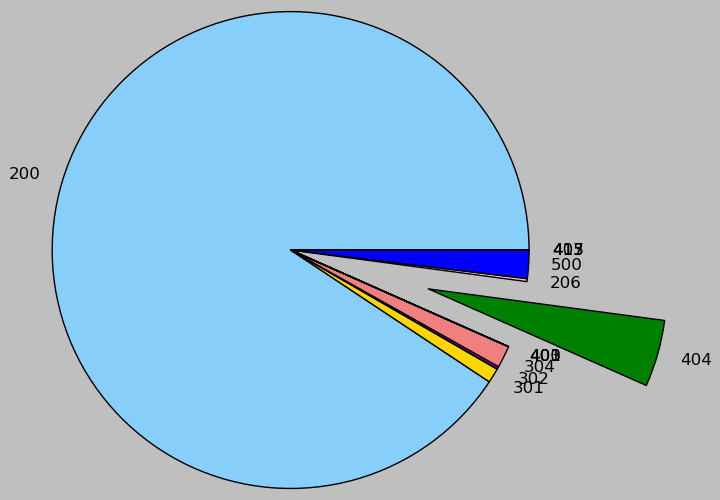

In [37]:
import matplotlib.pyplot as plt
colors = ['red', 'lightskyblue', 'gold', 'purple', 'lightcoral', 'yellow', 'black','orange', 'green', 'pink', 'blue',
         'aqua', 'darkgreen']
print labels
def fixPercent(percent):
    return "%.2f%%"%percent

# explode the 404 index out
explode = [0 if i != labels.index(404) else .6 for i in range(len(labels))]
assert len(explode) == len(colors) == len(labels), "explode array needs to correspond with the colors array"
plt.pie(proportions, labels = labels, colors=colors, explode= explode)
plt.axis('equal')

## That pie doesn't look too great with the tiny slices
plt.pie returns objects called autotexts.  These store info on whether or not a label should be displayed.
One can use this info to prettify the plot a bit.

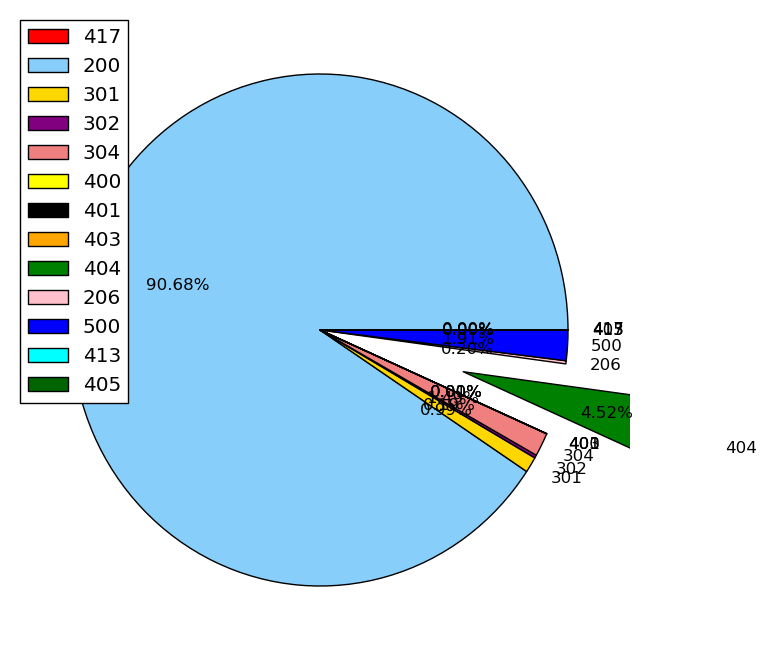

In [38]:
fig = plt.figure(figsize=(8,8), facecolor='white')
patches, texts, autotexts = plt.pie(proportions, labels=labels, colors=colors, 
                                    explode=explode, autopct=fixPercent)

for text, autotext in zip(texts, autotexts):
    if autotext.get_text() == '':
        text.set_text('')

plt.legend(labels, loc=0)

## Further analysis, temporal analysis

Let's get the extent of the time frames for the logs.

In [40]:
dates = successes.map(lambda r: r.date_time)

In [48]:
extent = (dates.min(), dates.max())
diff = extent[1] - extent[0]

In [54]:
"The data spans {} days or {:.2} years".format(diff.days, diff.days/float(365))

'The data spans 928 days or 2.5 years'

With datetime, you can get a unique representation of the time.  Along with that there are nifty features that allow you to check temporal analysis for weekday visits and weekend visits.

In [55]:
sample_dates = dates.take(3)

In [59]:
aDate = sample_dates[0]

In [73]:
aDate.day, aDate.weekday(), aDate.time(), aDate.toordinal()

(24, 0, datetime.time(15, 17, 1), 735043)

In [74]:
?aDate.toordinal

Ordinal is the method we're after, we can convert it to the ordinal number and then reconvert it back to a datetime representation.

So let's see how Myriams Table is doing unique daily visitor wise.

In [76]:
#  get an rdd of ordinal, host pairs
ordinalDatesWithHosts = successes.map(lambda r: (r.date_time.toordinal(), r.host)).cache()

In [78]:
ordinalDatesWithHosts.take(1)

[(735043, '8.225.212.178')]

In [79]:
# get distinct combos for day and host, ie a host can only have its presence once per day
uniqueHostsPerDay = ordinalDatesWithHosts.distinct()

In [83]:
# aggregate and cache
countsOfUniqueVisits = uniqueHostsPerDay.map(lambda t: (t[0],1)).reduceByKey(lambda a,b: a+b).cache()

So on which 10 days did myriams table reach the largest breadth of potential customers?

In [94]:
datetime.datetime.strftime(datetime.datetime.fromordinal(735478),"%b %d, %Y")

'Sep 02, 2014'

In [97]:
(countsOfUniqueVisits
    .map(lambda t: (datetime.datetime.strftime(datetime.datetime.fromordinal(t[0]), "%b %d, %Y"), t[1]))
     .takeOrdered(10, key=lambda t: -1*t[1]))

[('Sep 02, 2014', 4378),
 ('Jan 13, 2015', 3073),
 ('Sep 01, 2014', 1791),
 ('Nov 16, 2015', 1589),
 ('Oct 02, 2015', 1227),
 ('Nov 15, 2015', 1105),
 ('Oct 03, 2015', 947),
 ('Oct 12, 2015', 825),
 ('Oct 14, 2015', 817),
 ('Oct 15, 2015', 787)]

How about by overall daily requests?

In [102]:
(ordinalDatesWithHosts
 .map(lambda t: (t[0], 1))
 .reduceByKey(lambda a,b: a+b)
 .map(lambda t: (datetime.datetime.strftime(datetime.datetime.fromordinal(t[0]), "%b %d, %Y"), t[1])) 
 .takeOrdered(10, key=lambda t: -1*t[1]))

[('Sep 12, 2014', 129098),
 ('Sep 03, 2014', 35421),
 ('Sep 02, 2014', 29579),
 ('Dec 16, 2014', 27970),
 ('Sep 13, 2014', 23897),
 ('Jul 01, 2014', 22543),
 ('Mar 24, 2014', 18370),
 ('Jan 13, 2015', 17081),
 ('Oct 08, 2014', 8734),
 ('May 03, 2015', 7654)]